In [1]:
# main.ipynb content to be used in Jupyter Notebook format

# Section 1: Setup
import torch
import pandas as pd
from torch.utils.data import DataLoader
from src.adm_prednet.stacked_model import ADMStackedModel
from src.adm_prednet.pe_utils import add_temporal_pe, add_spatial_pe
from src.adm_prednet.masked_loss import masked_mse
from src.adm_prednet.evaluate import evaluate_model
from src.adm_prednet.save_predictions import save_predictions_to_csv
from src.adm_prednet.visualize_utils import plot_comparison
from src.adm_prednet.train import train_adm_model
from src.data_utils import split_data_chronologically


# Section 2: Load config
import yaml
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

# Section 3: Load data
full_df = pd.read_csv(cfg['data']['csv_path'])
train_df,val_df,test_df = split_data_chronologically(
    full_df,
    cfg
)





Splitting data: Train ends 2017-12-31 00:00:00, Validation ends 2020-12-31 00:00:00
Train set shape: (251316, 19), Time range: 1901-01-16 00:00:00 to 2017-12-16 00:00:00
Validation set shape: (6444, 19), Time range: 2018-01-16 00:00:00 to 2020-12-16 00:00:00
Test set shape: (6444, 19), Time range: 2021-01-16 00:00:00 to 2023-12-16 00:00:00


In [2]:
# main.ipynb content to be used in Jupyter Notebook format

# Section 1: Setup
import torch
import pandas as pd
from torch.utils.data import DataLoader
from src.adm_prednet.stacked_model import ADMStackedModel
from src.adm_prednet.pe_utils import add_temporal_pe, add_spatial_pe
from src.adm_prednet.masked_loss import masked_mse
from src.adm_prednet.evaluate import evaluate_model
from src.adm_prednet.save_predictions import save_predictions_to_csv
from src.adm_prednet.visualize_utils import plot_comparison
from src.grid_utils import create_gridded_data
from src.data_utils import split_data_chronologically

# Section 2: Load config
import yaml
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

# Section 3: Load and Grid Data
full_df = pd.read_csv(cfg['data']['csv_path'])
train_df, val_df,test_df = split_data_chronologically(full_df, cfg)
gridded_tensor, land_mask = create_gridded_data(val_df, cfg)

# Section 4: Dataset Class from Grid
from torch.utils.data import Dataset
class GriddedSeq2SeqDataset(Dataset):
    def __init__(self, gridded_tensor, input_steps=12, target_steps=1, target_indices=[0, 1]):
        self.data = torch.tensor(gridded_tensor, dtype=torch.float32)
        self.input_steps = input_steps
        self.target_steps = target_steps
        self.target_indices = target_indices
        self.grid_shape = self.data.shape[1:3]  # (H, W)

    def __len__(self):
        return self.data.shape[0] - self.input_steps - self.target_steps + 1

    def __getitem__(self, idx):
        X = self.data[idx:idx + self.input_steps]  # [T, H, W, C]
        X = X.permute(0, 3, 1, 2).float()           # → [T, C, H, W]
        Y = self.data[idx + self.input_steps]      # [H, W, C]
        Y = Y[..., self.target_indices].permute(2, 0, 1)  # [C_target, H, W]
        return X, Y

        




Splitting data: Train ends 2017-12-31 00:00:00, Validation ends 2020-12-31 00:00:00
Train set shape: (251316, 19), Time range: 1901-01-16 00:00:00 to 2017-12-16 00:00:00
Validation set shape: (6444, 19), Time range: 2018-01-16 00:00:00 to 2020-12-16 00:00:00
Test set shape: (6444, 19), Time range: 2021-01-16 00:00:00 to 2023-12-16 00:00:00
--- Starting Data Gridding Process (Fixed Step Method) ---
Using fixed grid step of: 0.5 degrees
Grid boundaries: LAT (6.25, 20.25), LON (97.75, 105.25)
Calculated grid dimensions: Height=29, Width=16
Created 2D validity mask (29x16) with 179 valid data pixels.
Pivoting data into a 4D tensor of shape (36, 29, 16, 15)...


c:\Users\peera\Desktop\DroughtLSTM_oneday\src\grid_utils.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['row_idx'] = ((df[lat_col] - lat_min) / fixed_step).round().astype(int)
c:\Users\peera\Desktop\DroughtLSTM_oneday\src\grid_utils.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['col_idx'] = ((df[lon_col] - lon_min) / fixed_step).round().astype(int)


--- Data Gridding Process Finished ---


In [3]:
train_dataset = GriddedSeq2SeqDataset(
    gridded_tensor,
    input_steps=cfg['training']['input_steps'],
    target_steps=cfg['training']['output_steps'],
    target_indices=list(range(len(cfg['model']['output_targets'])))
)
train_loader = DataLoader(train_dataset, batch_size=cfg['training']['batch_size'], shuffle=True)

val_dataset = GriddedSeq2SeqDataset(
    gridded_tensor,
    input_steps=cfg['training']['input_steps'],
    target_steps=cfg['training']['output_steps'],
    target_indices=list(range(len(cfg['model']['output_targets'])))
)
val_loader = DataLoader(val_dataset, batch_size=cfg['training']['batch_size'], shuffle=False)
test_dataset = GriddedSeq2SeqDataset(
    gridded_tensor,
    input_steps=cfg['training']['input_steps'],
    target_steps=cfg['training']['output_steps'],
    target_indices=list(range(len(cfg['model']['output_targets'])))
)
test_loader = DataLoader(test_dataset, batch_size=cfg['training']['batch_size'], shuffle=False)
# Section 4: Load model
model = ADMStackedModel(
    input_channels=cfg['model']['input_channels'],
    hidden_channels=cfg['model']['hidden_channels'],
    n_layers=cfg['model']['n_layers'],
    output_targets=cfg['model']['output_targets']
).cuda()

In [4]:
val_dataset = GriddedSeq2SeqDataset(
    gridded_tensor,
    input_steps=cfg['training']['input_steps'],
    target_steps=cfg['training']['output_steps'],
    target_indices=list(range(len(cfg['model']['output_targets'])))
)
val_loader = DataLoader(val_dataset, batch_size=cfg['training']['batch_size'], shuffle=False)

# Section 5: Load model
model = ADMStackedModel(
    input_channels=cfg['model']['input_channels'],
    hidden_channels=cfg['model']['hidden_channels'],
    n_layers=cfg['model']['n_layers'],
    output_targets=cfg['model']['output_targets']
).cuda()


In [5]:
import optuna
land_mask = torch.tensor(land_mask, dtype=torch.float32).cuda()

c:\Users\peera\.conda\envs\drought_lstm_base\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.1 is exactly one major version older than the runtime version 6.31.1 at api.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\peera\.conda\envs\drought_lstm_base\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#for testing purposes
train_loader = DataLoader(val_dataset, batch_size=cfg['training']['batch_size'], shuffle=True)
train_dataset = val_dataset
test_dataset = val_dataset
test_loader = val_loader


In [ ]:
# main.ipynb or objective function

def objective(trial, config, train_dataset, val_dataset, land_mask):
    """
    Objective function to be used by Optuna for hyperparameter optimization.
    """
    # Hyperparameters to be tuned
    n_layers = trial.suggest_int('n_layers', 2, 5)
    
    # Define hidden_channels as a list of n_layers
    hidden_channels = [trial.categorical(f'hidden_channels_{i}', [32,64,128,256]) for i in range(n_layers)]
    
    learning_rate = trial.suggest_loguniform('learning_rate', 2e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.3)
    batch_size = trial.suggest_int('batch_size', 8, 32, step=8)

    # Ensure hidden_channels is a list and its length matches n_layers
    assert isinstance(hidden_channels, list) and len(hidden_channels) == n_layers, "hidden_channels must be a list with length matching n_layers"
    
    # Create DataLoader with the current batch size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    # Update the config with the tuned hyperparameters
    config['model']['hidden_channels'] = hidden_channels
    config['model']['n_layers'] = n_layers
    config['training']['learning_rate'] = learning_rate
    config['training']['dropout_rate'] = dropout_rate

    # Train the model and get the evaluation metrics
    model = train_adm_model(train_loader, config, val_loader=val_loader, land_mask=land_mask)

    # Evaluate the model
    metrics = evaluate_model(model, val_loader, land_mask, output_targets=config['model']['output_targets'])

    # Return RMSE (or other metrics) for Optuna to optimize
    return metrics['PET']['RMSE']  # You can choose other targets if you want


In [8]:
land_mask.shape

torch.Size([29, 16])

In [9]:
# Set up the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, cfg, val_dataset, val_dataset, land_mask), n_trials=1)
# After the Optuna study is finished

# After the Optuna study is finished
best_params = study.best_trial.params

# Print the best hyperparameters
print("Best hyperparameters found by Optuna:", best_params)

# Reconstruct the hidden_channels list from Optuna's best parameters
n_layers = best_params['n_layers']  # Get the number of layers from the best trial
hidden_channels = [best_params[f'hidden_channels_{i}'] for i in range(n_layers)]  # Reconstruct hidden_channels list

print("Reconstructed hidden_channels:", hidden_channels)

# Assuming `cfg` is your model configuration
cfg_final = cfg.copy()

# Update the configuration dictionary with the best parameters from Optuna
cfg_final['model']['hidden_channels'] = hidden_channels
cfg_final['model']['n_layers'] = best_params['n_layers']
cfg_final['training']['learning_rate'] = best_params['learning_rate']
cfg_final['training']['dropout_rate'] = best_params['dropout_rate']
cfg_final['training']['batch_size'] = best_params['batch_size']

train_val_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
train_val_loader = DataLoader(train_val_dataset, batch_size=cfg_final['training']['batch_size'], shuffle=True)
# Train the final model using the best configuration from Optuna
final_model = train_adm_model(train_val_loader, cfg_final, val_loader=test_loader, land_mask=land_mask)

# Save the final model after training
torch.save(final_model.state_dict(), "final_model.pth")
# 5. Save the final model
torch.save(final_model.state_dict(), "final_model.pth")

# 6. Evaluate the final model
metrics = evaluate_model(final_model, test_loader, land_mask, output_targets=cfg['model']['output_targets'])


[I 2025-06-16 18:13:32,071] A new study created in memory with name: no-name-8ec7f656-84e2-464c-b546-851c557fa579
C:\Users\peera\AppData\Local\Temp\ipykernel_27456\2475644686.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\peera\AppData\Local\Temp\ipykernel_27456\2475644686.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)


Epoch 1 - Train Loss: 0.2087
Epoch 1 - Validation Loss: 0.2067
Epoch 2 - Train Loss: 0.2068
Epoch 2 - Validation Loss: 0.2044
Epoch 3 - Train Loss: 0.2046
Epoch 3 - Validation Loss: 0.2021
Epoch 4 - Train Loss: 0.2017
Epoch 4 - Validation Loss: 0.1994
Epoch 5 - Train Loss: 0.1995
Epoch 5 - Validation Loss: 0.1965
Epoch 6 - Train Loss: 0.1967
Epoch 6 - Validation Loss: 0.1932
Epoch 7 - Train Loss: 0.1936
Epoch 7 - Validation Loss: 0.1895
Epoch 8 - Train Loss: 0.1897
Epoch 8 - Validation Loss: 0.1859
Epoch 9 - Train Loss: 0.1872
Epoch 9 - Validation Loss: 0.1833
Epoch 10 - Train Loss: 0.1831
Epoch 10 - Validation Loss: 0.1835
Epoch 11 - Train Loss: 0.1852
Epoch 11 - Validation Loss: 0.1838
Epoch 12 - Train Loss: 0.1835
Epoch 12 - Validation Loss: 0.1812
Epoch 13 - Train Loss: 0.1827
Epoch 13 - Validation Loss: 0.1781
Epoch 14 - Train Loss: 0.1789
Epoch 14 - Validation Loss: 0.1756
Epoch 15 - Train Loss: 0.1775
Epoch 15 - Validation Loss: 0.1737
Epoch 16 - Train Loss: 0.1759
Epoch 16 - Va

[I 2025-06-16 18:15:07,228] Trial 0 finished with value: 0.24159036576747894 and parameters: {'n_layers': 3, 'hidden_channels_0': 20, 'hidden_channels_1': 97, 'hidden_channels_2': 106, 'learning_rate': 0.00016608215625672567, 'dropout_rate': 0.24151873138803226, 'batch_size': 24}. Best is trial 0 with value: 0.24159036576747894.


Best hyperparameters found by Optuna: {'n_layers': 3, 'hidden_channels_0': 20, 'hidden_channels_1': 97, 'hidden_channels_2': 106, 'learning_rate': 0.00016608215625672567, 'dropout_rate': 0.24151873138803226, 'batch_size': 24}
Reconstructed hidden_channels: [20, 97, 106]
Epoch 1 - Train Loss: 0.2134
Epoch 1 - Validation Loss: 0.2079
Epoch 2 - Train Loss: 0.2067
Epoch 2 - Validation Loss: 0.2015
Epoch 3 - Train Loss: 0.1997
Epoch 3 - Validation Loss: 0.1947
Epoch 4 - Train Loss: 0.1933
Epoch 4 - Validation Loss: 0.1878
Epoch 5 - Train Loss: 0.1848
Epoch 5 - Validation Loss: 0.1850
Epoch 6 - Train Loss: 0.1899
Epoch 6 - Validation Loss: 0.1865
Epoch 7 - Train Loss: 0.1869
Epoch 7 - Validation Loss: 0.1809
Epoch 8 - Train Loss: 0.1812
Epoch 8 - Validation Loss: 0.1775
Epoch 9 - Train Loss: 0.1774
Epoch 9 - Validation Loss: 0.1748
Epoch 10 - Train Loss: 0.1749
Epoch 10 - Validation Loss: 0.1711
Epoch 11 - Train Loss: 0.1699
Epoch 11 - Validation Loss: 0.1651
Epoch 12 - Train Loss: 0.1638
Ep

KeyboardInterrupt: 

Evaluation Metrics:
 {'PET': {'RMSE': np.float32(0.19897145), 'MAE': np.float32(0.1597113), 'R2': 0.9328159093856812}, 'PRE': {'RMSE': np.float32(0.16868888), 'MAE': np.float32(0.13468586), 'R2': 0.9237540364265442}}
Saved PET predictions to: run_outputs/predictions/PET_predictions.csv
Saved PRE predictions to: run_outputs/predictions/PRE_predictions.csv


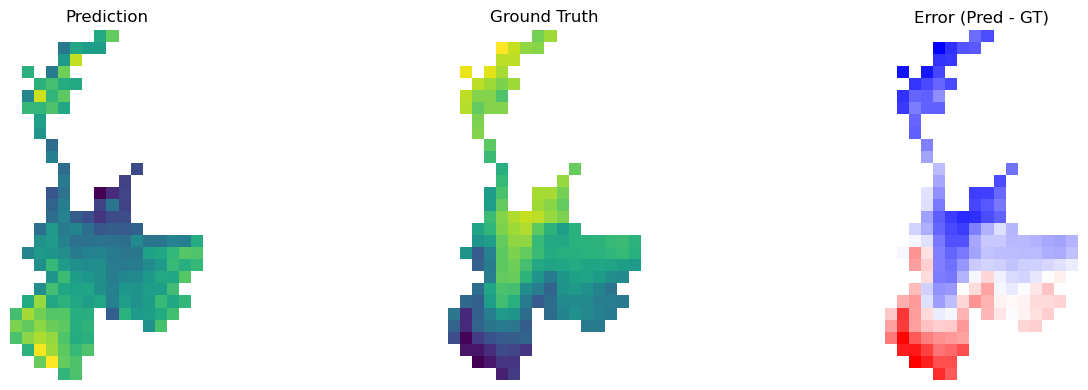

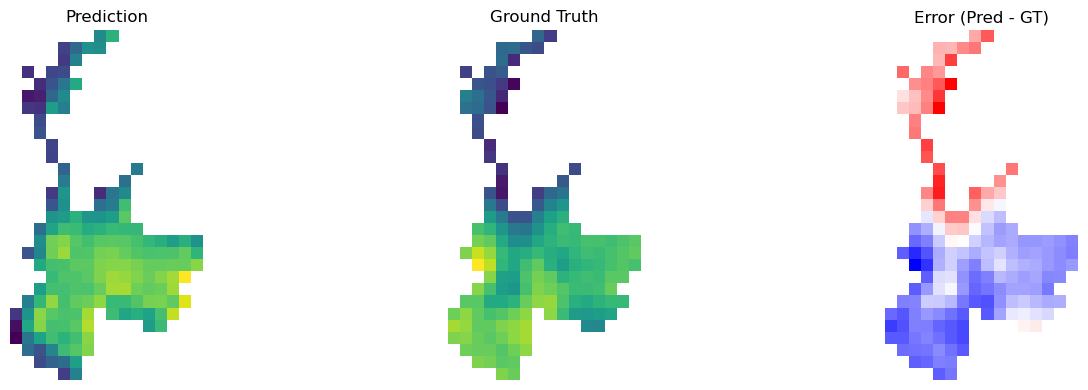

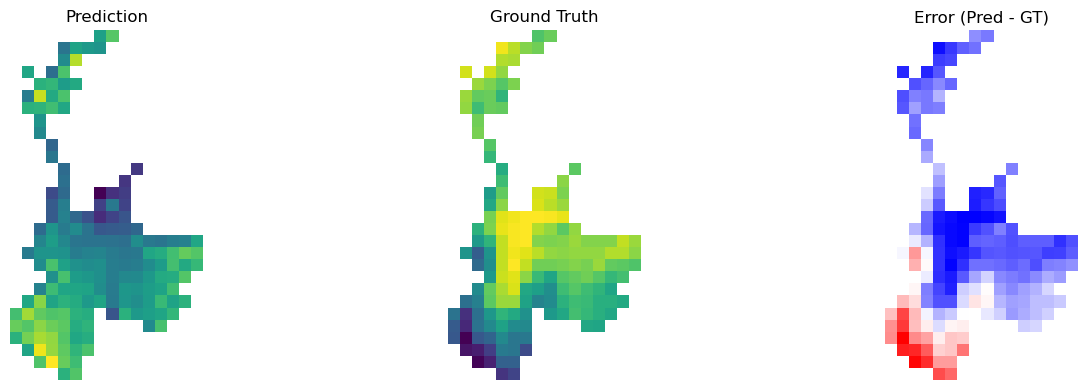

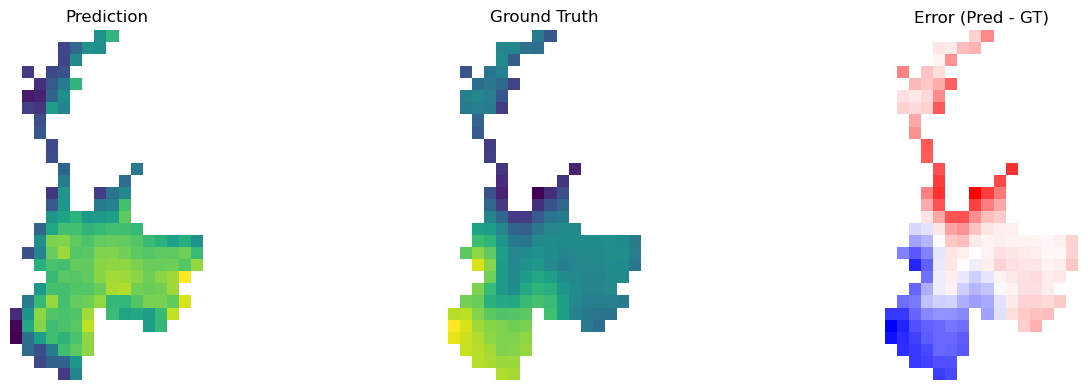

In [ ]:

metrics = evaluate_model(final_model, val_loader, land_mask, cfg['model']['output_targets'])
print("Evaluation Metrics:\n", metrics)

# Section 7: Predict and save
save_predictions_to_csv(final_model, val_loader, land_mask, cfg['model']['output_targets'], val_df, cfg['output']['predictions_csv'])

# Section 8: Visualize
if cfg['output']['visualize_samples']:
    for x_seq, y_true in val_loader:
        x_seq = add_temporal_pe(x_seq)
        x_seq = add_spatial_pe(x_seq)
        y_pred = model(x_seq.cuda()).cpu()
        for i in range(min(2, y_pred.shape[0])):
            for c, target in enumerate(cfg['model']['output_targets']):
                plot_comparison(y_pred[i, c], y_true[i, c], mask=land_mask, title=target)
        break

In [ ]:

print("Final Evaluation Metrics:", metrics)
# 7. Save predictions to CSV
save_predictions_to_csv(
    final_model,
    val_loader,
    land_mask,
    output_targets=cfg['model']['output_targets'],
    raw_df=val_df,
    output_dir=cfg['output']['predictions_csv'],
)

Final Evaluation Metrics: {'PET': {'RMSE': np.float32(0.19897145), 'MAE': np.float32(0.1597113), 'R2': 0.9328159093856812}, 'PRE': {'RMSE': np.float32(0.16868888), 'MAE': np.float32(0.13468586), 'R2': 0.9237540364265442}}
Saved PET predictions to: run_outputs/predictions/PET_predictions.csv
Saved PRE predictions to: run_outputs/predictions/PRE_predictions.csv
